# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Load the training data from train.csv file

In [0]:
import csv
with open("/content/drive/My Drive/DS/Data/Advanced CNN/train_labels.csv", 'r') as csvfile:
  images = list(csv.reader(csvfile, delimiter=";"))
train_labels = np.array(images[1:])

### Print the shape of the train dataset

In [116]:
train_labels.shape

(173, 1)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [118]:
with open("/content/drive/My Drive/DS/Data/Advanced CNN/train_labels.csv","r") as f:
  paths = []
  coords = np.zeros((sum(1 for line in range(1,174)), 4))
  print(coords.shape)
  reader = csv.reader(f, delimiter=",")
  f.seek(0)
  next(reader)
  for col,row in enumerate(reader):
    path, image_width, image_height,c,x0,y0,x1,y1 = row
    path = '/content/drive/My Drive/DS/Data/Advanced CNN/images_racoon/images/images/' + path
    paths.append(path)
    coords[col, 0] = int(x0) * IMAGE_SIZE / int(image_width)
    coords[col, 1] = int(y0) * IMAGE_SIZE / int(image_height)
    coords[col, 2] = (int(x1) - int(x0)) * IMAGE_SIZE / int(image_width)
    coords[col, 3] = (int(y1) - int(y0)) * IMAGE_SIZE / int(image_height)

(173, 4)


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
for i,im in enumerate(paths):
  img = Image.open(im)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0)

In [0]:
for layer in model.layers:
  layer.trainable = False

In [0]:
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x)

model = Model(inputs=model.input, outputs=x)

In [123]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [125]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

model.fit(batch_images, gt, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
173/173 [==============================] - 1s 7ms/step - loss: 2839.2991 - IoU: 0.0825
Epoch 2/30
173/173 [==============================] - 0s 671us/step - loss: 715.3765 - IoU: 0.4227
Epoch 3/30
173/173 [==============================] - 0s 586us/step - loss: 639.1809 - IoU: 0.5284
Epoch 4/30
173/173 [==============================] - 0s 601us/step - loss: 562.6788 - IoU: 0.5342
Epoch 5/30
173/173 [==============================] - 0s 545us/step - loss: 336.8049 - IoU: 0.5866
Epoch 6/30
173/173 [==============================] - 0s 561us/step - loss: 269.9314 - IoU: 0.5905
Epoch 7/30
173/173 [==============================] - 0s 548us/step - loss: 236.3788 - IoU: 0.6133
Epoch 8/30
173/173 [==============================] - 0s 560us/step - loss: 192.6761 - IoU: 0.6659
Epoch 9/30
173/173 [==============================] - 0s 517us/step - loss: 168.1014 - IoU: 0.7002
Epoch 10/30
173/173 [==============================] - 0s 517us/step - loss: 141.3810 - IoU: 0.7183
Epoch 11/3

### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/DS/Data/Advanced CNN/images_racoon/images/images/raccoon-2.jpg'
unscaled = cv2.imread(filename)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
ih, iw, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0]

In [0]:
x0 = int(region[0] * iw / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * ih / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * iw / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * ih / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

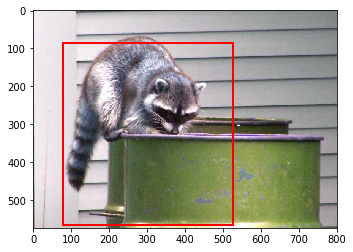

In [130]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import the necessary libraries

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

### Load your data file

In [0]:
df = pd.read_csv('/content/drive/My Drive/DS/Data/NLP/lstm/daily-minimum-temperatures-in-me.csv', index_col='Date')

In [135]:
df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Plot data

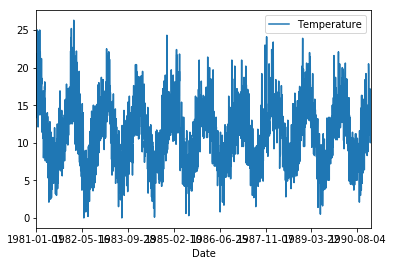

In [136]:
df.plot()

#### Descibe your dataframe

In [137]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [139]:
df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values

In [0]:
#df.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94f4320ac8>]],
      dtype=object)

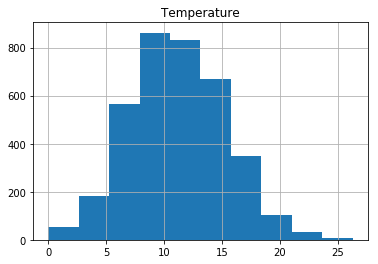

In [141]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [143]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df)

#### Check the maximum and minimum values of scaled data

In [146]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [149]:
scaled[9:15]

array([[0.76045627],
       [0.61596958],
       [0.50570342],
       [0.63498099],
       [0.81749049],
       [0.95057034]])

### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [151]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [153]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806083650190113
1
X 1 to 2
[0.68060837]
Y 2
0.714828897338403
2
X 2 to 3
[0.7148289]
Y 3
0.5551330798479087
3
X 3 to 4
[0.55513308]
Y 4
0.6007604562737643
4
X 4 to 5
[0.60076046]
Y 5
0.6007604562737643
5
X 5 to 6
[0.60076046]
Y 6
0.6007604562737643
6
X 6 to 7
[0.60076046]
Y 7
0.6615969581749048
7
X 7 to 8
[0.66159696]
Y 8
0.8288973384030418
8
X 8 to 9
[0.82889734]
Y 9
0.7604562737642585
9
X 9 to 10
[0.76045627]
Y 10
0.6159695817490494
10
X 10 to 11
[0.61596958]
Y 11
0.5057034220532319
11
X 11 to 12
[0.50570342]
Y 12
0.6349809885931559
12
X 12 to 13
[0.63498099]
Y 13
0.8174904942965779
13
X 13 to 14
[0.81749049]
Y 14
0.9505703422053232
14
X 14 to 15
[0.95057034]
Y 15
0.7870722433460076
15
X 15 to 16
[0.78707224]
Y 16
0.7832699619771863
16
X 16 to 17
[0.78326996]
Y 17
0.9429657794676806
17
X 17 to 18
[0.94296578]
Y 18
0.6730038022813688
18
X 18 to 19
[0.6730038]
Y 19
0.5893536121673003
19
X 19 to 20
[0.58935361]
Y 20
0.6920152091254752
20
X 20 to 21


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [154]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

### Summarize your model

In [157]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [158]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/50
 - 13s - loss: 0.0254
Epoch 2/50
 - 11s - loss: 0.0166
Epoch 3/50
 - 11s - loss: 0.0136
Epoch 4/50
 - 11s - loss: 0.0118
Epoch 5/50
 - 11s - loss: 0.0112
Epoch 6/50
 - 11s - loss: 0.0107
Epoch 7/50
 - 11s - loss: 0.0104
Epoch 8/50
 - 11s - loss: 0.0103
Epoch 9/50
 - 11s - loss: 0.0102
Epoch 10/50
 - 11s - loss: 0.0104
Epoch 11/50
 - 11s - loss: 0.0102
Epoch 12/50
 - 11s - loss: 0.0102
Epoch 13/50
 - 11s - loss: 0.0102
Epoch 14/50
 - 11s - loss: 0.0102
Epoch 15/50
 - 11s - loss: 0.0102
Epoch 16/50
 - 11s - loss: 0.0101
Epoch 17/50
 - 11s - loss: 0.0101
Epoch 18/50
 - 11s - loss: 0.0101
Epoch 19/50
 - 11s - loss: 0.0101
Epoch 20/50
 - 11s - loss: 0.0101
Epoch 21/50
 - 11s - loss: 0.0102
Epoch 22/50
 - 11s - loss: 0.0101
Epoch 23/50
 - 11s - loss: 0.0102
Epoch 24/50
 - 11s - loss: 0.0102
Epoch 25/50
 - 11s - loss: 0.0102
Epoch 26/50
 - 11s - loss: 0.0102
Epoch 27/50
 - 11s - loss: 0.0102
Epoch 28/50
 - 11s - loss: 0.0103
Epoch 29/50
 - 11s - loss: 0.0102
Epoch 30/50
 - 11s - lo

## Make Predictions and Evaluate your model

In [159]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.51 RMSE


## Plot the results

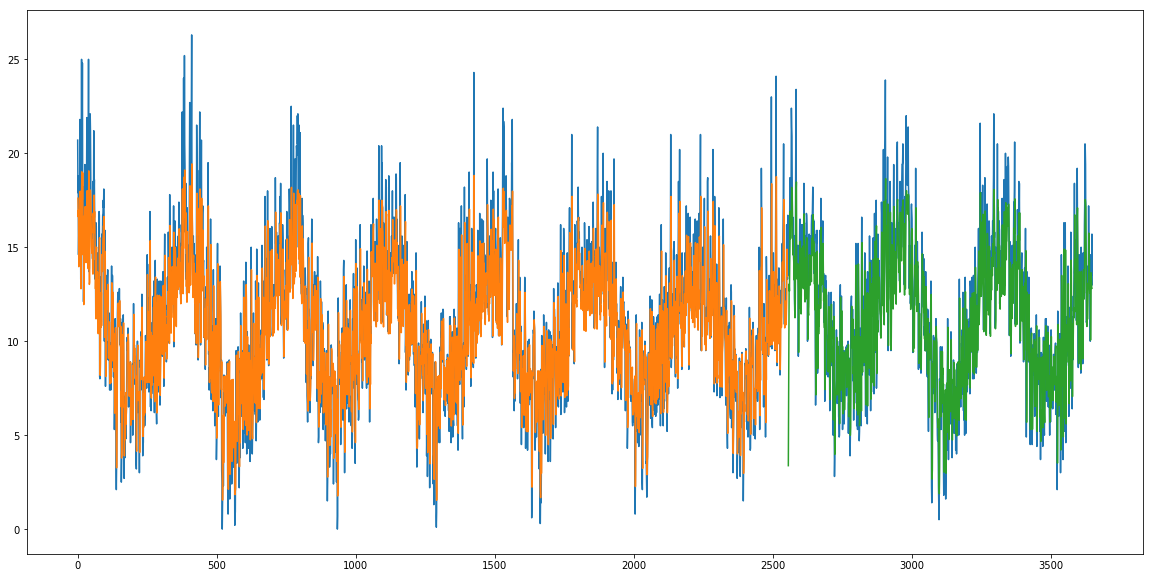

In [160]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()